In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

anime = pd.read_csv('anime.csv')
ratings =pd.read_csv('rating.csv')

print("=" * 60)
print("ANIME DATASET")
print("=" * 60)
print(anime.head())
print(f"\nShape: {anime.shape}")
print(f"Columns: {anime.columns.tolist()}")

print("\n" + "=" * 60)
print("RATINGS DATASET")
print("=" * 60)
print(ratings.head())
print(f"\nShape: {ratings.shape}")
print(f"Columns: {ratings.columns.tolist()}")

ANIME DATASET
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  

Shape: (12294, 7)
Columns: ['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members']

RATINGS DATASET
   user_id  anim

In [9]:
print("missing values in anime datatset")
print (anime.isnull().sum())
print("\n"+"=" * 60)

print("missing values in ratings datatset")
print (ratings.isnull().sum())
print("\n"+"=" * 60)

print("\n anime datatypes")
print (anime.dtypes)
print("\n"+"=" * 60)

print("\n basic statistics")
print(anime.describe())


missing values in anime datatset
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

missing values in ratings datatset
user_id     0
anime_id    0
rating      0
dtype: int64


 anime datatypes
anime_id      int64
name            str
genre           str
type            str
episodes        str
rating      float64
members       int64
dtype: object


 basic statistics
           anime_id        rating       members
count  12294.000000  12064.000000  1.229400e+04
mean   14058.221653      6.473902  1.807134e+04
std    11455.294701      1.026746  5.482068e+04
min        1.000000      1.670000  5.000000e+00
25%     3484.250000      5.880000  2.250000e+02
50%    10260.500000      6.570000  1.550000e+03
75%    24794.500000      7.180000  9.437000e+03
max    34527.000000     10.000000  1.013917e+06


In [10]:
print(f"original anime rows: {len(anime)}")
print(f"original ratings rows: {len(ratings)}")

anime_clean=anime.dropna(subset=['name','genre']).copy()
ratings_clean=ratings[ratings.rating!=-1].copy()

print(f"\nAfter cleaning:")
print(f"Anime rows: {len(anime_clean)}")
print(f"Ratings rows: {len(ratings_clean)}")

print(f"\nTotal unique anime: {anime_clean['anime_id'].nunique()}")
print(f"Total unique users: {ratings_clean['user_id'].nunique()}")
print(f"Total ratings: {len(ratings_clean)}")

original anime rows: 12294
original ratings rows: 7813737

After cleaning:
Anime rows: 12232
Ratings rows: 6337241

Total unique anime: 12232
Total unique users: 69600
Total ratings: 6337241


In [11]:
popular_anime=ratings_clean.groupby('anime_id').agg({'rating':['count','mean']}).reset_index()
popular_anime.columns=['anime_id','rating_count','rating_mean']

popular_anime=popular_anime.merge(anime_clean[['anime_id','name','genre','type']],on='anime_id')

popular_anime=popular_anime.sort_values(by='rating_count',ascending=False)

print("TOP 10 MOST RATED ANIME:")
print("=" * 80)
print(popular_anime.head(10)[['name', 'rating_count', 'rating_mean', 'genre']])

TOP 10 MOST RATED ANIME:
                                    name  rating_count  rating_mean  \
1388                          Death Note         34226     8.834629   
6323                    Sword Art Online         26310     8.140213   
7059                  Shingeki no Kyojin         25290     8.725741   
1426     Code Geass: Hangyaku no Lelouch         24126     8.927796   
4567                        Angel Beats!         23565     8.549714   
201                           Elfen Lied         23528     8.064434   
10                                Naruto         22071     7.893888   
3936    Fullmetal Alchemist: Brotherhood         21494     9.322741   
99                   Fullmetal Alchemist         21332     8.453356   
2642  Code Geass: Hangyaku no Lelouch R2         21124     9.059837   

                                                  genre  
1388  Mystery, Police, Psychological, Supernatural, ...  
6323          Action, Adventure, Fantasy, Game, Romance  
7059       Action, 

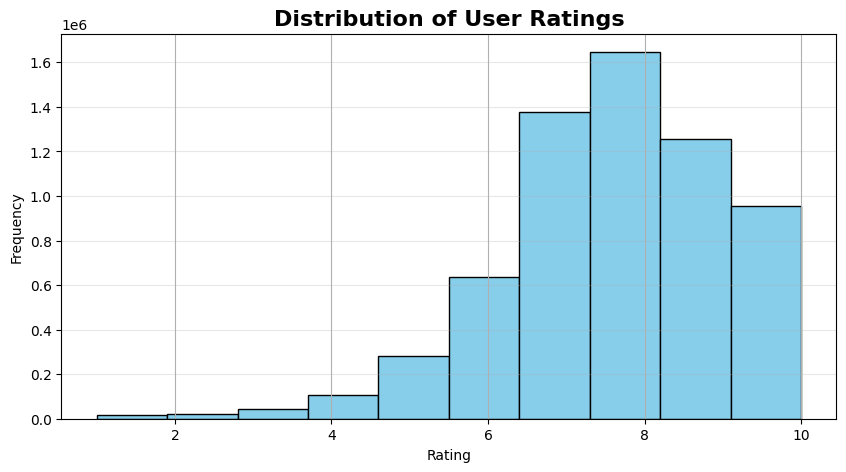

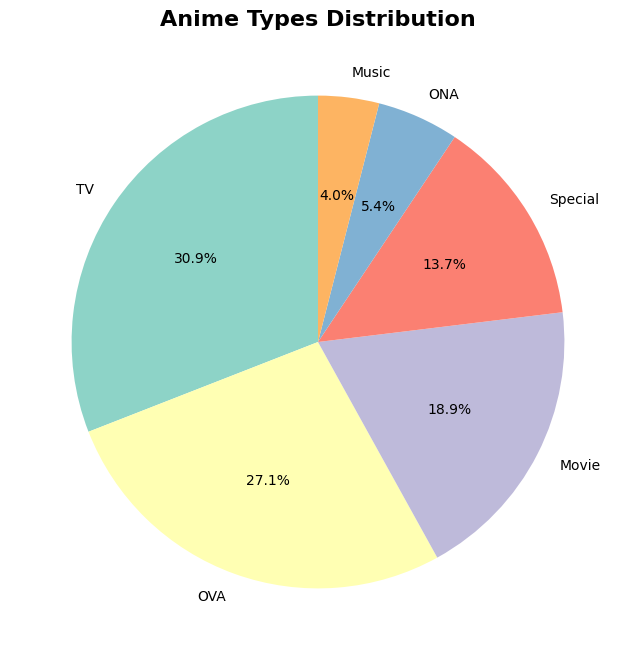

In [12]:
plt.figure(figsize=(10, 5))
ratings_clean['rating'].hist(bins=10, edgecolor='black', color='skyblue')
plt.title('Distribution of User Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.show()

plt.figure(figsize=(8, 8))
anime_clean['type'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set3.colors
)
plt.title('Anime Types Distribution', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class ContentBasedRecommender:
    def __init__(self, anime_df):
        self.anime_df = anime_df.copy()
        self.anime_df['genre'] = self.anime_df['genre'].fillna('')

        # Create TF-IDF matrix for genres
        self.tfidf = TfidfVectorizer(stop_words='english')
        self.tfidf_matrix = self.tfidf.fit_transform(self.anime_df['genre'])

        # Calculate similarity between all anime
        self.cosine_sim = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)

        print("✅ Content-Based Recommender initialized!")
        print(f"   Loaded {len(self.anime_df)} anime")

    def get_recommendations(self, anime_name, n=10):
        """Get similar anime based on genres"""
        # Find the anime
        matches = self.anime_df[self.anime_df['name'].str.contains(anime_name, case=False, na=False)]

        if len(matches) == 0:
            return f"❌ Anime '{anime_name}' not found! Try searching for it first."

        # Use first match
        idx = matches.index[0]
        anime_match = self.anime_df.loc[idx, 'name']

        print(f"🎯 Finding anime similar to: {anime_match}")
        print(f"   Genre: {self.anime_df.loc[idx, 'genre']}")
        print()

        # Get similarity scores
        sim_scores = list(enumerate(self.cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:n+1]  # Exclude the anime itself

        # Get anime indices
        anime_indices = [i[0] for i in sim_scores]

        # Return recommendations with scores
        recommendations = self.anime_df.iloc[anime_indices][['name', 'genre', 'rating', 'type']].copy()
        recommendations['similarity_score'] = [round(i[1], 3) for i in sim_scores]

        return recommendations

# Initialize the recommender
content_rec = ContentBasedRecommender(anime_clean)

✅ Content-Based Recommender initialized!
   Loaded 12232 anime


In [14]:
# Test with Death Note
print("📺 IF YOU LIKED 'DEATH NOTE', YOU MIGHT LIKE:")
print("=" * 80)
recs = content_rec.get_recommendations('Death Note', n=5)
print(recs.to_string(index=False))

📺 IF YOU LIKED 'DEATH NOTE', YOU MIGHT LIKE:
🎯 Finding anime similar to: Death Note
   Genre: Mystery, Police, Psychological, Supernatural, Thriller

                         name                                                           genre  rating    type  similarity_score
           Death Note Rewrite          Mystery, Police, Psychological, Supernatural, Thriller    7.84 Special             1.000
              Mousou Dairinin   Drama, Mystery, Police, Psychological, Supernatural, Thriller    7.74      TV             0.968
Higurashi no Naku Koro ni Kai                  Mystery, Psychological, Supernatural, Thriller    8.41      TV             0.880
Higurashi no Naku Koro ni Rei          Comedy, Mystery, Psychological, Supernatural, Thriller    7.56     OVA             0.861
             Mirai Nikki (TV) Action, Mystery, Psychological, Shounen, Supernatural, Thriller    8.07      TV             0.816
